# [Kaggle: Predicting a Biological Response](https://www.kaggle.com/c/bioresponse)
(Прогнозирование биологического ответа)

##### Необходимо предсказать биологический ответ молекул (столбец 'Activity') по их химическому составу (столбцы D1-D1776).

Данные представлены в формате CSV.  
* Каждая строка представляет молекулу. 
* Первый столбец Activity содержит экспериментальные данные, описывающие фактический биологический ответ [0, 1]; 
* Остальные столбцы D1-D1776 представляют собой молекулярные дескрипторы — это вычисляемые свойства, которые могут фиксировать некоторые характеристики молекулы, например размер, форму или состав элементов.

Предварительная обработка не требуется, данные уже закодированы и нормализованы.

В качестве метрики будем использовать F1-score.

Необходимо обучить две модели: логистическую регрессию и случайный лес. 

Далее нужно сделать подбор гиперпараметров с помощью базовых и продвинутых методов оптимизации. 

Важно использовать все четыре метода (GridSeachCV, RandomizedSearchCV, Hyperopt, Optuna) хотя бы по разу, максимальное количество итераций не должно превышать 50.

In [2]:
# импорт библиотек
import numpy as np # для матричных вычислений
import pandas as pd # для анализа и предобработки данных
import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # для визуализации

from sklearn import linear_model # линейные моделиё
from sklearn import tree # деревья решений
from sklearn import ensemble # ансамбли
from sklearn import metrics # метрики
from sklearn import preprocessing # предобработка
from sklearn import model_selection
from sklearn.model_selection import train_test_split # сплитование выборки

%matplotlib inline
plt.style.use('seaborn')

### Знакомство с данными и их исследование

In [7]:
data = pd.read_csv('data/_train_sem09__1_.zip')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


In [8]:
TARGET_FEATURE = 'Activity'

Проверяем наличие пропусков

In [10]:
empty_cols = data.isnull().sum()
empty_cols[empty_cols > 0]

Series([], dtype: int64)

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3751 entries, 0 to 3750
Columns: 1777 entries, Activity to D1776
dtypes: float64(942), int64(835)
memory usage: 50.9 MB


Смотрим на сбалансированность классов:

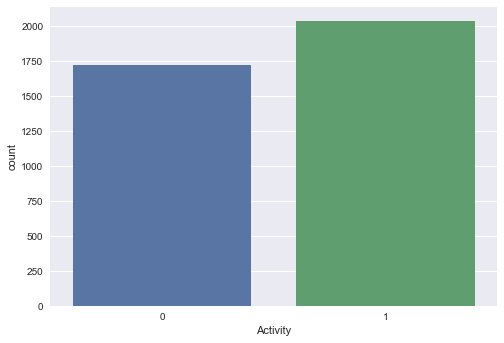

In [12]:
sns.countplot(data=data, x=TARGET_FEATURE);

In [ ]:
data[TARGET_FEATURE].value_counts(True)

Оцениваем мультиколинеарность и взаимосвязь с целевым признаком

Создаем матрицу наблюдений $X$ и вектор ответов $y$

In [15]:
X, y = data.drop(['income'], axis=1), dummies_data['income']

* Разделяем выборку на тренировочную и тестовую в соотношении 80/20. 
* Для сохранения соотношений целевого признака используем параметр stratify (стратифицированное разбиение). 

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

Производим нормализацию данных с помощью min-max нормализации

In [17]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Оптимизация гиперпараметров модели

#### **Логистическая регрессия**

Зафиксируем только метрики, которые были получены без дополнительной настройки, т.е со значениями гиперпараметров, установленных по умолчанию:

In [18]:
# Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(max_iter = 1000)

# Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

print(f'accuracy_score на train наборе: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print()
print(f'accuracy_score на test наборе: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')

accuracy_score на train наборе: 0.84
f1_score на train наборе: 0.64

accuracy_score на test наборе: 0.84
f1_score на test наборе: 0.64


## 3. Продвинутая оптимизация.

Оценка качества модели для каждой комбинации гиперпараметров является дорогостоящей частью оптимизации, поэтому в идеале мы хотим делать это самым эффективным образом. Один из способов  — это выбор следующей комбинации гиперпараметров на основе прошлых результатов. 
Байесовская оптимизация отличается от случайного поиска или поиска по сетке тем, что делает именно это: вместо того, чтобы просто выбирать комбинации из сетки, не имеющей информации о прошлых оценках, байесовские методы учитывают предыдущие результаты, чтобы попробовать более многообещающие комбинации значений. Это позволяет во многих случаях найти лучшие значения гиперпараметров модели за меньшее количество времени.
Таким образом, мы получаем и более быструю оптимизацию, и более качественный результат. Это два желаемых результата, особенно когда мы работаем с настройкой гиперпараметров моделей машинного обучения.

## <center> Optuna

Optuna - это достаточно новый фреймворк/библиотека, разработанный специально для оптимизации гиперпараметров. Помимо байесовских алгоритмов, есть возможность удаления плохих комбинаций из рассмотрения. По умолчанию удаляет комбинации, в которых модель дает качество ниже медианы из уже рассмотренных. Optuna помогает  быстрее находить лучшие гиперпараметры и работает с большинством современных известных библиотек ML, таких как scikit-learn, xgboost, PyTorch, TensorFlow, skorch, lightgbm, Keras, fast-ai и др.

In [19]:
# Устанавливаем библиотеку
# !pip install optuna
# или
#!conda install -c conda-forge optuna

In [20]:
import optuna
print(f'Версия Optuna: {optuna.__version__}')

Версия Optuna: 2.10.1


Настроим оптимизацию гиперпараметров для алгоритма случайного леса.

In [21]:
random_state = 42

In [31]:
def optuna_rf(trial, cv=5):
  """ Функция для оптимизации

  Args:
      trial (_type_): _description_
      cv (int, optional): Количество фолдов кросс-валидации. По умолчанию 0, кросс-валидация не используется.

  Returns:
      _type_: _description_
  """
  
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 300, 1)
  max_depth = trial.suggest_int('max_depth', 5, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 15, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  
  if cv > 0:
    # Создаём объект кросс-валидатора k-fold со стратификацией
    skf = model_selection.StratifiedKFold(n_splits=cv)
    
    # Считаем метрики на кросс-валидации k-fold со стратификацией
    cv_metrics = model_selection.cross_validate(
        estimator=model, # модель
        X=X_train_scaled, # матрица наблюдений X
        y=y_train, # вектор ответов y
        cv=skf, # кросс-валидатор
        scoring='f1', # метрика
        return_train_score=False # подсчёт метрики на тренировочных фолдах
    )
    score = np.mean(cv_metrics['test_score'])
  else:
    # обучаем модель
    model.fit(X_train_scaled, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train_scaled))
  
  return score

In [32]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику через direction
study = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')

# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2022-09-12 15:42:39,821] A new study created in memory with name: RandomForestClassifier
[I 2022-09-12 15:42:50,040] Trial 0 finished with value: 0.6474246367031908 and parameters: {'n_estimators': 167, 'max_depth': 17, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.6474246367031908.
[I 2022-09-12 15:42:57,454] Trial 1 finished with value: 0.6237808878863318 and parameters: {'n_estimators': 140, 'max_depth': 11, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.6474246367031908.
[I 2022-09-12 15:43:09,522] Trial 2 finished with value: 0.6512939148527129 and parameters: {'n_estimators': 196, 'max_depth': 20, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.6512939148527129.
[I 2022-09-12 15:43:18,979] Trial 3 finished with value: 0.6383394380761465 and parameters: {'n_estimators': 151, 'max_depth': 17, 'min_samples_leaf': 14}. Best is trial 2 with value: 0.6512939148527129.
[I 2022-09-12 15:43:37,952] Trial 4 finished with value: 0.6437371066580899 and parameters: {'n

CPU times: total: 4min 50s
Wall time: 4min 56s


In [33]:
# выводим результаты на обучающей выборке
print(f'Наилучшие значения гиперпараметров {study.best_params}')
print(f'f1_score на обучающем наборе: {study.best_value:.2f}')

Наилучшие значения гиперпараметров {'n_estimators': 299, 'max_depth': 29, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.67


In [34]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params, random_state=random_state,)

# Обучаем модель
model.fit(X_train_scaled, y_train)

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print(f'accuracy_score на train наборе: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print()
print(f'accuracy_score на test наборе: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')

accuracy_score на train наборе: 0.92
f1_score на train наборе: 0.82

accuracy_score на test наборе: 0.86
f1_score на test наборе: 0.68


In [35]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(n_estimators=299, max_depth=29, min_samples_leaf=2, random_state=random_state,)

# Обучаем модель
model.fit(X_train_scaled, y_train)

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print(f'accuracy_score на train наборе: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print()
print(f'accuracy_score на test наборе: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')

accuracy_score на train наборе: 0.92
f1_score на train наборе: 0.82

accuracy_score на test наборе: 0.86
f1_score на test наборе: 0.68


In [27]:
%%time
# можем прододжить подбор, указав n_trials(любое число, которое добавится к предыдущим итерациям) 
study.optimize(optuna_rf, n_trials=10)

[I 2022-09-12 14:00:09,565] Trial 20 finished with value: 0.702648401826484 and parameters: {'n_estimators': 262, 'max_depth': 27, 'min_samples_leaf': 7}. Best is trial 17 with value: 0.8130296610169492.
[I 2022-09-12 14:00:13,542] Trial 21 finished with value: 0.7948148805824381 and parameters: {'n_estimators': 196, 'max_depth': 23, 'min_samples_leaf': 2}. Best is trial 17 with value: 0.8130296610169492.
[I 2022-09-12 14:00:16,932] Trial 22 finished with value: 0.7552761562640323 and parameters: {'n_estimators': 171, 'max_depth': 24, 'min_samples_leaf': 3}. Best is trial 17 with value: 0.8130296610169492.
[I 2022-09-12 14:00:20,519] Trial 23 finished with value: 0.7388454978005208 and parameters: {'n_estimators': 183, 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 17 with value: 0.8130296610169492.
[I 2022-09-12 14:00:23,577] Trial 24 finished with value: 0.7585529254131308 and parameters: {'n_estimators': 146, 'max_depth': 27, 'min_samples_leaf': 3}. Best is trial 17 with val

CPU times: total: 40.1 s
Wall time: 40.1 s


In [28]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )

# Обучаем модель
model.fit(X_train_scaled, y_train)

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print(f'accuracy_score на train наборе: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print()
print(f'accuracy_score на test наборе: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')

accuracy_score на train наборе: 0.92
f1_score на train наборе: 0.81

accuracy_score на test наборе: 0.86
f1_score на test наборе: 0.67


**Видим, что Optuna также удалось увеличить метрику, но за меньшее время, чем Hyperopt.**

Рассмотрим различные визуализации, доступные через Optuna, которые помогают принимать лучшие решения, видеть влияние различных гиперпараметров на производительность модели.

Сначало необходимо проверить, доступна ли поддержка визуализации: is_available (), т.е. доступны ли правильные версии plotly и matplotlib для создания визуализаций.

In [29]:
optuna.visualization.is_available()

True

График истории оптимизации - отображает количество испытаний на оси Х и метрику на оси Y.

Следует использовать эту диаграмму, чтобы проверить, идет ли оптимизация гиперпараметров в правильном направлении или нет.

In [30]:
optuna.visualization.plot_optimization_history(study, target_name="f1_score")

В нашем случае, все идет верно, метрика максимизируется.

График важности гиперпараметров - помогает понять, какие гиперпараметры вносят больший вклад в минимизацию/максимизацию метрики.

In [31]:
optuna.visualization.plot_param_importances(study, target_name="f1_score")

Из этого графика можно сделать вывод, что стоит обратить большее внимание на настройку гиперпараметра min_sampeles_leaf

График контура отношений гиперпараметров

Он показывает связь между различными комбинациями гиперпараметров и значение метрики для этих комбинаций в виде контурного графика.

In [32]:
optuna.visualization.plot_contour(study, params=["max_depth", "n_estimators"],
                                  target_name="f1_score")

Точки с белым фоном это и есть лучшии комбинации n_estimator, max_depth.
















### Задание 3.10
Реализуйте настройку гиперпараметров алгоритма RandomForestClassifier(random_state=42) со следующей сеткой значений:
* n_estimators = от 100 до 300 включительно с шагом 10
* min_samples_leaf = от 3 до 7 с шагом 1
* max_depth = от 15 до 40 с шагом 1

Используйте Optuna с параметрами n_trails = 20.

In [ ]:
trials = Trials() # используется для логирования результатов

In [33]:
def optuna_rf(trial, cv=0):
  """ Функция для оптимизации

  Args:
      trial (_type_): _description_
      cv (int, optional): Количество фолдов кросс-валидации. По умолчанию 0, кросс-валидация не используется.

  Returns:
      _type_: _description_
  """
  
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 300, 10)
  max_depth = trial.suggest_int('max_depth', 15, 40, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 3, 7, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  
  if cv > 0:
    # Создаём объект кросс-валидатора k-fold со стратификацией
    skf = model_selection.StratifiedKFold(n_splits=cv)
    
    # Считаем метрики на кросс-валидации k-fold со стратификацией
    cv_metrics = model_selection.cross_validate(
        estimator=model, # модель
        X=X_train_scaled, # матрица наблюдений X
        y=y_train, # вектор ответов y
        cv=skf, # кросс-валидатор
        scoring='f1', # метрика
        return_train_score=False # подсчёт метрики на тренировочных фолдах
    )
    score = np.mean(cv_metrics['test_score'])
  else:
    # обучаем модель
    model.fit(X_train_scaled, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train_scaled))
  
  return score

In [34]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику через direction
study = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')

# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf(cv=5), n_trials=20)

[I 2022-09-12 14:00:51,242] A new study created in memory with name: RandomForestClassifier


TypeError: optuna_rf() missing 1 required positional argument: 'trial'

In [ ]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )

# Обучаем модель
model.fit(X_train_scaled, y_train)

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print(f'accuracy_score на train наборе: {metrics.accuracy_score(y_train, y_train_pred):.2f}')
print(f'f1_score на train наборе: {metrics.f1_score(y_train, y_train_pred):.2f}')
print()
print(f'accuracy_score на test наборе: {metrics.accuracy_score(y_test, y_test_pred):.2f}')
print(f'f1_score на test наборе: {metrics.f1_score(y_test, y_test_pred):.2f}')

accuracy_score на train наборе: 0.90
f1_score на train наборе: 0.77

accuracy_score на test наборе: 0.86
f1_score на test наборе: 0.68
